Для A/B теста взят за основу взят датасет с сайта Caggle.

Сайт запустил A/B-тест с целью увеличения дохода. Файл Excel содержит исходные данные о результатах эксперимента (user id), типе выборки (variant name) и доходе, полученном пользователем (revenue).
Задача состоит в том, чтобы проанализировать результаты эксперимента и написать свои рекомендации.

Для начала импортируем все необходимые библиотеки

In [35]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5,4)

pd.options.mode.chained_assignment = None

# Загрузка и обработка данных

In [3]:
df = pd.read_csv('data/AB_Test_Results.csv')
df.head(2)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0


In [4]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [5]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Проверим, есть ли пользователи, у которые попали в обе тестовые группы

In [6]:
# рассмотрим распределение количества уникальных групп для каждого пользователя

double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [7]:
# Также рассмотрим в относительном выражении

double_variant_count / double_variant_count.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

Мы видим, что такие пользователи есть, и их довольно много - 24%. Если мы примем во внимание этих пользователей, то исследование изменений в эксперименте будет менее точным. Поэтому нам следует исключить эти пользовательские данные из расчета

In [8]:
# во-первых, давайте посмотрим, у каких пользователей есть одна тестовая группа

single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)

# а затем возьмем только этих пользователей

single_variant_users = single_variant_users[single_variant_users]

In [9]:
# оставим записи только для пользователей с 1-й тестовой группой ab

df = df[df['USER_ID'].isin(single_variant_users.index)]

# на всякий случай проверим, соответствует ли количество пользователей тому, что было до исключения

df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

Посмотрим, как распределяются данные

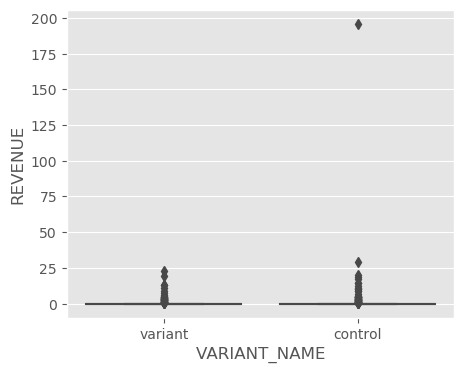

In [18]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

Сразу бросается в глаза, что в данных есть сильный выброс. Его можно найти, отсортировав эти значения дохода в порядке убывания

In [19]:
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


Давайте посмотрим, были ли у пользователя 3342 другие события с сильным выбросом

In [20]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


Мы видим, что есть только один выброс. Мы удалим эту запись и снова посмотрим на распределение данных

In [21]:
df = df[df['USER_ID'] != 3342]

([<matplotlib.axis.XTick at 0x7f0b503c6b20>,
 <a list of 2 Text xticklabel objects>)

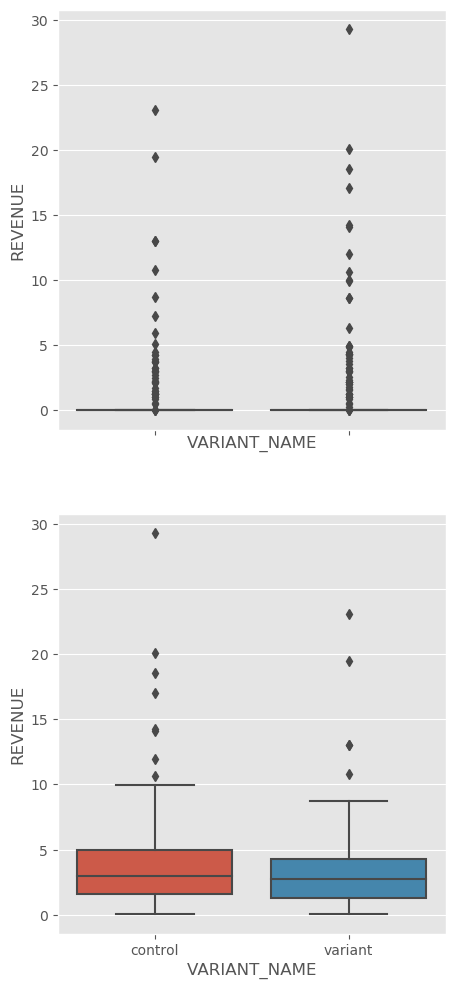

In [22]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

Мы видим, что у большинства пользователей нет покупок. Давайте посмотрим, что это за пустые покупки: либо это информация обо всех пользователях, независимо от их действий (даже при отсутствии посещений и положительных покупок), либо эти записи проставляются в случае входа без покупок и могут быть другие записи с положительным доходом.

In [23]:
# давайте посмотрим, есть ли пользователи, у которых есть записи с нулевым и положительным доходом

(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)), 
    'USER_ID'
]).count()

52

Один и тот же пользователь действительно может иметь записи как с нулевым, так и с положительным доходом.

Давайте предположим, что записи представляют собой посещения сервиса пользователями, а экспериментальная единица - пользователя. Затем мы группируем данные для каждого пользователя и суммируем доход для каждого, чтобы получить по одной записи на пользователя

In [24]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

Посмотрим на распределение, получившиеся в итоге

([<matplotlib.axis.XTick at 0x7f0b502b3700>,
 <a list of 2 Text xticklabel objects>)

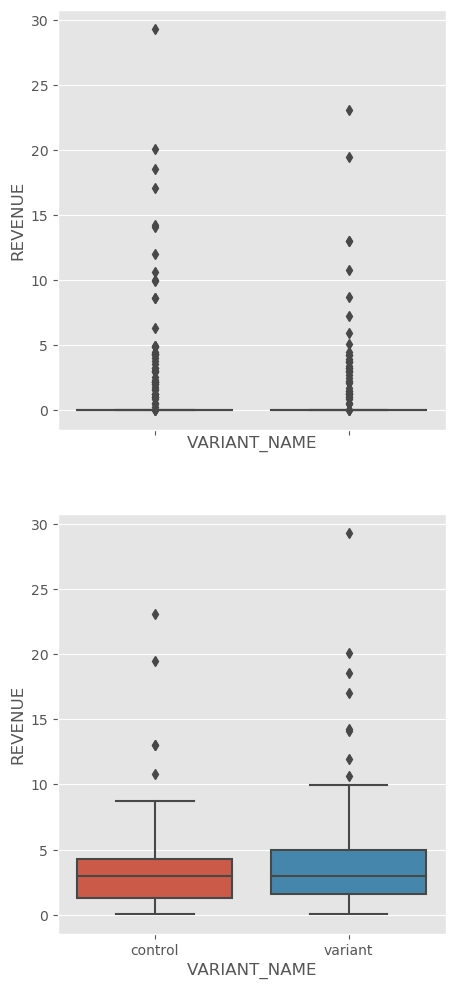

In [26]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

Следует отметить, что во время преобразования квантили в тестовой группе увеличились

Видно, что в тестовой группе почти вся квантильная статистика, за исключением минимальной, находится на несколько более низком уровне.

Давайте посмотрим на различные статистические данные в контексте тестовых групп AB для всех пользователей

In [28]:
# Метрики по группам
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# создаем две дополнительные метрики, чтобы увидеть относительные изменения
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# добавим их к остальным показателям в отдельную группу
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

Мы видим, что в тестовой группе общая сумма выручки и средний чек на одного пользователя снизились, но количество заказов на одного пользователя немного увеличилось.

Давайте также посмотрим, как ведут себя заплатившие пользователи

In [29]:
# Метрики по группам
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

# создаем две дополнительные метрики, чтобы увидеть относительные изменения
orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

Давайте посмотрим на распределение всех и только заплативших пользователей

/tmp/ipykernel_22317/2694907780.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a nu

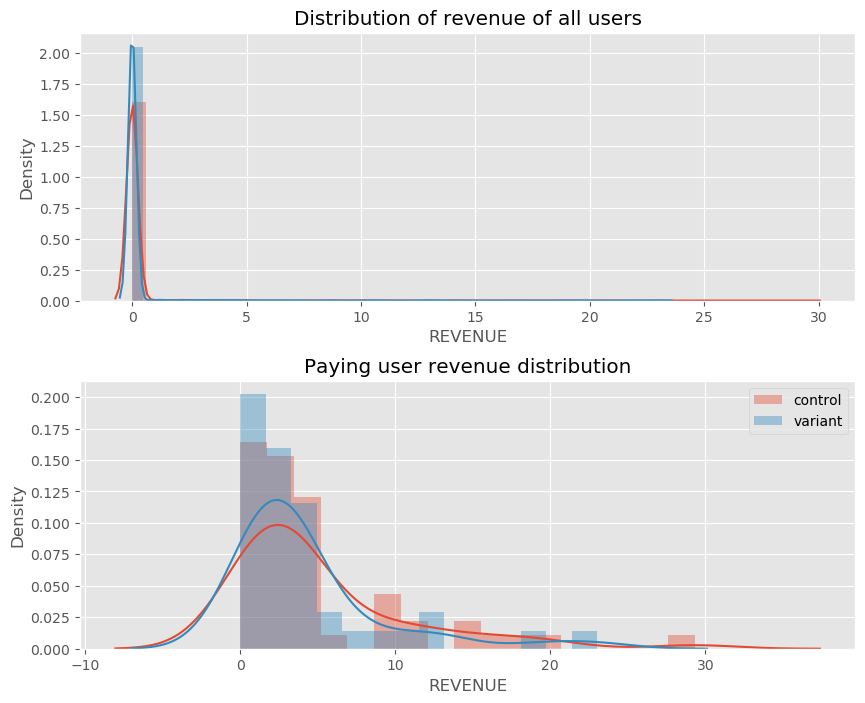

In [33]:
f, axes = plt.subplots(2, figsize=(10,8))
# Графики распределения всех пользователей
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# Графики распределения заплативших пользователей
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

# Статистический анализ

## Проверка того, является ли распределение нормальным

Основываясь на их предыдущем графике, мы видим, что данные распределены ненормально, но на всякий случай мы можем подтвердить это формально, используя критерий Шапиро-Уилка

In [36]:
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

(0.06145977973937988, 0.0)

Нулевая гипотеза о нормальном распределении данных отвергается

## Тест Мана - Уитни

давайте проверим значение статистики теста Манна-Уитни. Некоторые источники имеют ограничение применимости в случае дублирования данных. В нашей выборке много повторений, и особенно много нулевых значений, поэтому в данном случае нам нужно быть осторожными с этим критерием.

In [38]:
(df['REVENUE'] == 0).value_counts()

True     4687
False      95
Name: REVENUE, dtype: int64

Давайте сначала проверим данные всех пользователей

In [39]:
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.12399777553410979)

Проверка только для оплативших пользователей

In [40]:
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.2657096108542354)

## Бутстреп

Чтобы получить более полную информацию о различиях между средними значениями тестовых групп ab, мы будем использовать bootstap.

Это статистическая процедура, которая выбирает один набор данных для создания множества смоделированных выборок. Этот процесс позволяет вам вычислять стандартные ошибки, строить доверительные интервалы и выполнять проверку гипотез. Основное различие между начальной загрузкой и статистическим тестом заключается в том, что bootstrap можно использовать для вычисления p-значений или доверительных интервалов в любой ситуации, включая те, которые не подходят для t-тестов или любого другого известного теста. Например, при начальной загрузке мы можем сравнивать медианы или режимы вместо средних значений, и мы не можем сделать это с помощью статистического теста.

Шаги начальной загрузки следующие:

Выберите количество образцов начальной загрузки для выполнения (например, 1000).

Выберите размер выборки.

Для каждого образца начальной загрузки:
Нарисуйте образец с заменой на выбранный размер.
Рассчитайте статистику по выборке.
Повторите шаг 3 много раз (номер шага 1)

In [41]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Давайте сгенерируем образцы для всех пользователей

In [43]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

Сгенерируем образцы для оплативших пользователей

In [45]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Давайте посмотрим на распределение средних значений в тестовых группах ab

Text(0.5, 1.0, 'Sample mean distribution for all users')

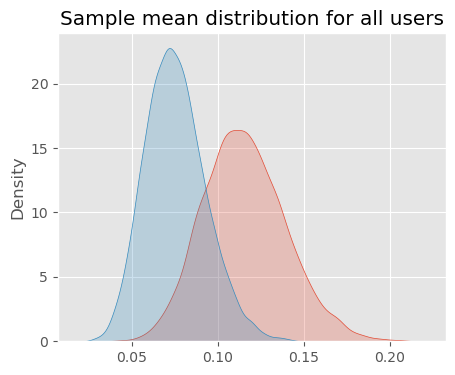

In [53]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), fill=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), fill=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

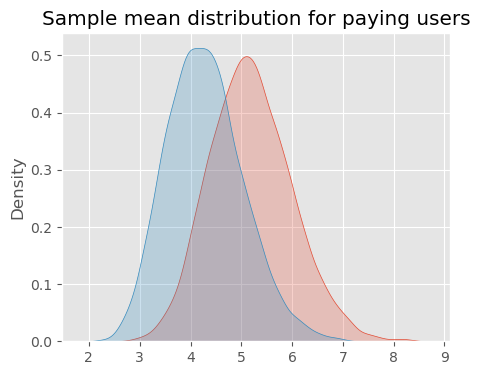

In [52]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), fill=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), fill=True, label='variant')
plt.title('Sample mean distribution for paying users')

Мы видим, что различия есть, но доверительные интервалы могут перекрываться, поэтому вам нужно посмотреть на распределение разницы в средних между группами, чтобы сделать окончательные выводы.

Давайте оценим разницу между группами: посмотрим на распределение средней разницы и построим для нее доверительные интервалы. Для этого мы создадим функцию для визуализации

In [54]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, fill=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

IndexError: list index out of range

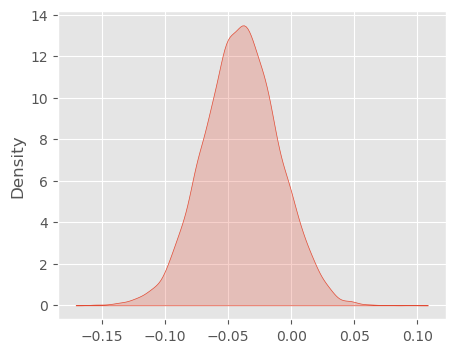

In [55]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1), 
                                      np.mean(control, axis=1),
                                      title='all users')

IndexError: list index out of range

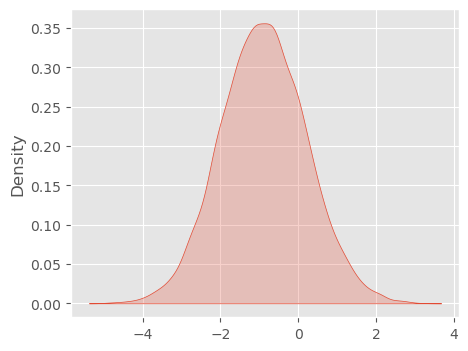

In [56]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1), 
                                     np.mean(control_paid, axis=1), 
                                     title='paying users')

# Выводы и рекомендации

Чтобы сделать выводы об изменениях между группами тестирования ab, сначала в данные были внесены следующие изменения:

Пользователи с двумя тестовыми группами ab были исключены, чтобы сделать эффект изменений более выраженным, был исключен User_id=3342, поскольку в условиях ограниченной информации это сильный выброс в полученной выборке Пользователи берутся в качестве экспериментальной единицы, а затем данные группируются по каждому пользователю и доходам и суммируется по каждому, чтобы получить по одной записи на пользователя Несмотря на то, что доход в тестовой группе значительно снизился, статистически значимых изменений между группами тестирования ab не было, как среди всех пользователей, так и только среди платящей аудитории. Для более глубокого анализа будут полезны данные теста A/A и дальнейшего изучения силы критериев.

Рекомендации:

Контрольный вариант должен быть реализован на 100%, поскольку статистическая значимость между группами отсутствует.

Я бы также проверил, нет ли каких-либо ошибок при назначении пользователю нескольких групп вариантов на веб-сайте.